In [1]:
# !pip install stop_words
!pip install vncorenlp
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.2.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.2.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/
!pip install swifter
!pip install rouge_score

The syntax of the command is incorrect.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'mv' is not recognized as an internal or external command,
operable program or batch file.
'mv' is not recognized as an internal or external command,
operable program or batch file.
'mv' is not recognized as an internal or external command,
operable program or batch file.


### Import Library

In [103]:
import pandas as pd
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras 
import time
import re
import pickle

from vncorenlp import VnCoreNLP
import string
from tqdm import tqdm

import swifter

from datasets import load_metric

### Loading Data

In [2]:
folder_path = '/kaggle/input/dataset2'
all_files = glob.glob(folder_path + "/*.csv")

files_to_skip = ['Dataset_articles_NoID-5.csv','Dataset_articles_NoID-6.csv', 'Dataset_articles_NoID-7.csv']
list_data = []
for file in all_files:
    if os.path.basename(file) in files_to_skip:
        continue
    df = pd.read_csv(file)
    list_data.append(df)
data = pd.concat(list_data, ignore_index=True)

In [107]:
data.shape

(200000, 8)

In [108]:
data.drop(['URL', 'Title', 'Date', 'Author(s)', 'Category', 'Tags'], axis=1, inplace=True)

In [109]:
data.head()

,Summary,Contents
0,Công đoàn Công nghiệp Hoá chất Việt Nam vừa tổ...,Thực hiện kế hoạch công tác năm 2020 của Ủy ba...
1,Cuộc trò chuyện của tôi và chị Phạm Thị Bích H...,"Điều mà chị Hải làm được, để vừa bảo vệ được q..."
2,"Tại tỉnh Đồng Nai, do ảnh hưởng của dịch COVID...",Cụ thể là trường hợp 4 cán bộ Công đoàn (CĐ) g...
3,"Phát huy nguồn lực Công đoàn, An Giang quyết t...",Chủ tịch LĐLĐ tỉnh An Giang Nguyễn Thiện Phú c...
4,Công đoàn Dầu khí Việt Nam đã tổ chức Tập huấ...,"Tại buổi tập huấn, các cán bộ Công đoàn được g..."


In [110]:
data.shape

(200000, 2)

In [72]:
data[data.isna().any(axis=1)]

,Summary,Contents
56,1.200 nữ CNLĐ đang làm việc trong môi trường n...,NaN
90,LĐLĐ TP. Rạch Giá (Kiên Giang) tổ chức cho nữ...,NaN
98,Thành phố Đà Nẵng đang sơ tán khoảng 72.000 ng...,NaN
463,LĐLĐ TP. Rạch Giá (Kiên Giang) vừa gắn biển cô...,NaN
504,"Suốt 20 năm qua, nhà giáo Ngô Hồng Khiêm đã là...",NaN
...,...,...
198777,"Sáng ngày 24.5, Đội quản lí thị trường số 6 (C...",NaN
198920,"Ông Nguyễn Hiếu Hoàng (55 tuổi, ngụ ấp 5, xã S...",NaN
198981,"Phát hiện nhóm trộm một xe SH của người dân, h...",NaN
199096,"Sáng ngày 7.5, đại diện Viện Kiểm sát nhân dân...",NaN


In [73]:
data = data.dropna()

In [74]:
data.shape

(197315, 2)

In [75]:
# data[data.duplicated(keep=False)]
data[data.duplicated()]

,Summary,Contents
9028,"Sáng nay 9.5, CĐ ngành Xây dựng Hà Nội phối hợ...","Theo đó, Tháng hành động về ATVSLĐ năm 2019 củ..."
15677,"Sáng ngày 12.10, tại TP.Vũng Tàu, đoàn công tá...",Hiệu quả trong đại hội công đoàn các cấp\n Tại...
16721,Ông Vi Văn Nghĩa - Chủ tịch LĐLĐ tỉnh Bắc Kạn ...,"Theo LĐLĐ tỉnh Bắc Kạn, trong 6 tháng đầu năm,..."
16737,"Có một điều tưởng như nghịch lý, nhưng lại diễ...",CN Hoàng Ngọc Hiển (bộ phận may) của Cty CP Dệ...
16765,"Nhiều năm nay, công ty tổ chức nấu ăn tại chỗ,...","Nhiều người bàn tán rằng, đằng sau lý do “tiết..."
...,...,...
199721,"Chị Hồng Hạnh (Đống Đa, Hà Nội) hỏi: Tôi đóng ...",BHXH Việt Nam trả lời: Về thời gian hưởng chế ...
199742,Công an huyện Can Lộc (Hà Tĩnh) vừa ra quyết đ...,"Sáng nay (21.3), thông tin với PV báo Lao Động..."
199879,Tỉnh Đắk Lắk đề nghị huyện Krông Pắk đề xuất b...,Liên quan đến việc huyện Krông Pắk chấm dứt hợ...
199913,"Anh Vũ Hải (Hà Đông, TP.Hà Nội) hỏi: Vợ tôi vừ...","Về nội dung bạn hỏi, BHXH TP.Hà Nội trả lời nh..."


In [76]:
data = data.drop_duplicates()

In [77]:
data.shape

(181291, 2)

In [78]:
data

,Summary,Contents
0,Công đoàn Công nghiệp Hoá chất Việt Nam vừa tổ...,Thực hiện kế hoạch công tác năm 2020 của Ủy ba...
1,Cuộc trò chuyện của tôi và chị Phạm Thị Bích H...,"Điều mà chị Hải làm được, để vừa bảo vệ được q..."
2,"Tại tỉnh Đồng Nai, do ảnh hưởng của dịch COVID...",Cụ thể là trường hợp 4 cán bộ Công đoàn (CĐ) g...
3,"Phát huy nguồn lực Công đoàn, An Giang quyết t...",Chủ tịch LĐLĐ tỉnh An Giang Nguyễn Thiện Phú c...
4,Công đoàn Dầu khí Việt Nam đã tổ chức Tập huấ...,"Tại buổi tập huấn, các cán bộ Công đoàn được g..."
...,...,...
199995,Sau khi “chiến dịch” giành lại vỉa hè ở Hà Nội...,"Xử lý vỉa hè như “ném đá, ao bèo” Ghi nhận của..."
199996,"Do hát karaoke quá to, người đàn ông bị một ng...","Vụ án mạng xảy ra vào khoảng 11h45 ngày 28.2, ..."
199997,"Ngày 28.2, Công an huyện Bố Trạch (tỉnh Quảng ...","Theo đó, cơ quan công an đã ra quyết định khởi..."
199998,"Ngày 28.2, TAND TP.Biên Hòa (Đồng Nai) đã mở p...","Sau khi khai mạc phiên tòa, luật sư bào chữa c..."


In [23]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [374]:
rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.2.jar", annotators="wseg", max_heap_size='-Xmx2g')
# stopwords = get_stop_words('vi')
translator = str.maketrans('', '', '!"“”#$&\'*+/:;<=>?@[\\]^_`{|}~\n')

def process_text(text: str):
    text = text.replace("\xa0", " ")
    text = re.sub(r'\S+@\S+', '', text)
    text = text.translate(translator)
    text = rdrsegmenter.tokenize(text)
    text = ' '.join([' '.join(x) for x in text])
    return text


In [92]:
temp = """ 35,5% Phó Chủ tịch domanhhung@gmail.com Trương Đình Luật ngày 14.3 EgyptAir mua 10 quả táo, ông Ahmed Adel, không loại trừ khả năng máy bay bị đặt bom hoặc bị đe dọa từ bên trong.
Máy bay bị đặt bom 1-12-2022 Kịch bản nhận được sự ủng hộ nhiều nhất đó là chiếc Airbus A320 bị một người nào đó tuồn bom lên khoang máy bay, sau đó kích nổ. Bộ trưởng Hàng không Ai Cập Sherif Fathy nghiêng về khả năng MS804 bị khủng bố nhiều hơn là trục trặc kỹ thuật.
Các quan chức Mỹ cũng tập trung vào giả quyết 3,5% máy bay bị khủng bố. Họ nghi ngờ một quả bom khiến máy bay nổ tung, sau đó rơi xuống biển. Tuy nhiên, các quan chức này lưu ý đây chỉ là phỏng đoán dựa trên hoàn cảnh thực tế chứ không phải dựa trên những bằng chứng xác thực.
Khả năng những kẻ khủng bố đưa bom trót lọt lên máy bay không phải không có cơ sở. Theo một báo cáo của Trung tâm Phòng chống Khủng bố (TCS, Mỹ), các nhóm khủng bố đến từ Yemen, Syria và Đông Phi đã và đang sáng tạo ra cách thức tuồn bom lên máy bay bằng cách qua mặt hệ thống kiểm tra an ninh. Hoặc chúng có thể sử dụng tay trong là một số người làm trong lĩnh vực hàng không để thực hiện mục đích.
“Nhiều sân bay tại các nước đang phát triển không trang bị công nghệ quét hiện đại cũng như không triển khai các khóa đào tạo nghiêm ngặt đối với các nhà khai thác” – báo cáo của TCS nêu rõ. Báo cáo cũng trích dẫn sự cố một chuyến bay rời khỏi Mogadishu – Somalia vào ngày 2-2 vừa qua. Hai nhân viên sân bay không hiểu bằng cách nào đã mang được một chiếc máy tính xách tay cài thiết bị nổ đi qua máy quét tia X mà không bị phát hiện.
Sau đó, 2 người này đưa máy tính cho 1 người đàn ông bắt chuyến bay tới Djibouti. Khoảng 20 phút sau khi máy bay cất cánh, chiếc máy tính phát nổ, khoét 1 lỗ thủng lớn ở thân máy bay. Người đàn ông cấm máy tính bị hút ra ngoài và rơi xuống đất thiệt mạng.
Chiếc máy bay chở hơn 70 hành khách lúc đó chưa đặt tới độ cao cần thiết đã hạ cánh khấn cấp, may mắn không gặp thêm sự cố nào.
Mối đe dọa từ bên trong"""
process_text(temp)

'35,5% Phó Chủ_tịch Trương_Đình_Luật ngày 14.3 EgyptAir mua 10 quả táo , ông Ahmed_Adel , không loại_trừ khả_năng máy_bay bị đặt bom hoặc bị đe_doạ từ bên trong.Máy bay bị đặt bom 1-12-2022 Kịch_bản nhận được sự ủng_hộ nhiều nhất đó là chiếc Airbus A320 bị một người nào đó tuồn bom lên khoang máy_bay , sau đó kích nổ . Bộ_trưởng Hàng_không Ai_Cập Sherif_Fathy nghiêng về khả_năng MS804 bị khủng_bố nhiều hơn là trục_trặc kỹ thuật.Các quan_chức Mỹ cũng tập_trung vào giả quyết 3,5% máy_bay bị khủng_bố . Họ nghi_ngờ một quả bom khiến máy_bay nổ tung , sau đó rơi xuống biển . Tuy_nhiên , các quan_chức này lưu_ý đây chỉ là phỏng_đoán dựa trên hoàn_cảnh thực_tế chứ không phải dựa trên những bằng_chứng xác thực.Khả năng những kẻ khủng_bố đưa bom trót_lọt lên máy_bay không phải không có cơ_sở . Theo một báo_cáo của Trung_tâm Phòng_chống Khủng_bố ( TCS , Mỹ ) , các nhóm khủng_bố đến từ Yemen , Syria và Đông_Phi đã và đang sáng_tạo ra cách_thức tuồn bom lên máy_bay bằng cách qua_mặt hệ_thống kiểm_

In [3]:
# document_proces = data['Contents'].swifter.apply(process_text)
# summary_proces = data['Summary'].swifter.apply(process_text)
# document_proces.to_csv('/kaggle/working/document_process.csv', index=False, encoding='utf-8')
# summary_proces.to_csv('/kaggle/working/summary_process.csv', index=False, encoding='utf-8')
# dataframe = pd.concat([document_proces, summary_proces], axis=1)
# dataframe.to_csv('/kaggle/working/data_process.csv', index=False)

In [283]:
data = pd.read_csv('/kaggle/input/data-processed/data_process.csv')

In [4]:
# data = data[data['Contents'].swifter.apply(lambda x: 50 < len(x.split()) <= 512)]
# data = data[data['Summary'].swifter.apply(lambda x: 5 < len(x.split()) <= 128)]
data = data[data['Contents'].swifter.apply(lambda x: 50 < len(x.split()))]
data = data[data['Summary'].swifter.apply(lambda x: 5 < len(x.split()))]

In [285]:
data.shape

(143503, 2)

In [286]:
document = data['Contents']
summary = data['Summary']

In [289]:
document[10], summary[10]

('Ngày 1.1.2022 , Khu du_lịch quốc_gia Núi Sam , TP. Châu_Đốc ( An_Giang ) chính_thức hoạt_động trở_lại trong trạng_thái bình_thường mới , sau thời_gian tạm dừng để thực_hiện phòng_chống dịch COVID-19 . Theo đó , phục_hồi toàn_diện hoạt_động sản_xuất , kinh_doanh , dịch_vụ , du_lịch , … trong trạng_thái bình_thường mới . Cụ_thể , các hoạt_động hành_hương , du_lịch tâm_linh , thăm_viếng các danh_thắng chính_thức trở_lại . Du_khách đến đây , thoải_mái thưởng_lãm , dâng hương tại các di_tích , như miếu Bà_Chúa Xứ_Núi_Sam , chùa Tây_An , Lăng_Thoại_Ngọc_Hầu ... Các hoạt_động dịch_vụ cũng chính_thức trở_lại hoạt_động phục_vụ du_khách . Bên cạnh các hoạt_động dịch_vụ ăn_uống , nghỉ_ngơi , dịch_vụ cáp treo đưa du_khách lên đỉnh núi Sam cũng chính_thức phục_vụ trở_lại . Trước đó , UBND TP. Châu_Đốc đã chủ_động ban_hành kế_hoạch thích_ứng linh_hoạt . Theo đó , phân_công cụ_thể từng ngành , bộ_phận như Công_an , Y_tế .... theo_dõi và linh_hoạt kiểm_soát hiệu_quả dịch COVID-19 trên địa_bàn , nhất

### Preprocessing

In [290]:
# for decoder sequence
summary = summary.apply(lambda x: '[START] ' + x + ' [END]')
summary.head()

0    [START] Như Quỳnh từng bị kỳ_thị , xa_lánh vì ...
1    [START] Trong tập mới của Bây_giờ , chúng_ta đ...
2    [START] Album của NCT tiếp_tục càn_quét các vị...
3    [START] Vốn nổi_tiếng là một trong những mỹ_nh...
4    [START] Sáng ngày 1.1 , mạng xã_hội xôn_xao tr...
Name: Summary, dtype: object

#### Tokenizing the texts into integer tokens

In [291]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [292]:
filters = '!"#$%&()*+,-./:;<=>?@\\^`{|}~\t\n'
oov_token = '<unk>'

In [293]:
document_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)

In [294]:
document_tokenizer.fit_on_texts(document)
summary_tokenizer.fit_on_texts(summary)

In [296]:
inputs = document_tokenizer.texts_to_sequences(document)
targets = summary_tokenizer.texts_to_sequences(summary)

In [299]:
document_tokenizer.texts_to_sequences(["Theo cơ_quan công_an"])

[[34, 324, 363]]

In [300]:
document_tokenizer.sequences_to_texts([[34, 324, 363]])

['theo cơ_quan công_an']

In [301]:
encoder_vocab_size = len(document_tokenizer.word_index) + 1
decoder_vocab_size = len(summary_tokenizer.word_index) + 1

# vocab_size
encoder_vocab_size, decoder_vocab_size

(296159, 63342)

#### Lấy thông tin bộ dữ liệu

In [302]:
document_lengths = pd.Series([len(x) for x in inputs])
summary_lengths = pd.Series([len(x) for x in targets])

In [303]:
document_lengths.idxmax()

90113

In [304]:
document[89579]

'Vào_khoảng 3h , ngày 31.3 , tại khai_trường Tây_Bắc_Ngã_Hai , Công_trường 01 , Công_ty 35 , Tổng_công_ty Đông_Bắc , nằm trên địa_bàn xã Dương_Huy , TP. Cẩm_Phả xảy ra vụ tụt vì_chống lò than , khiến 6 công_nhân bị mắc_kẹt trong lò . Ngay sau khi nhận thông_tin , ông Nguyễn_Xuân_Ký – Bí_thư tỉnh_uỷ Quảng_Ninh – đã chỉ_đạo Phó bí_thư thường_trực tỉnh_uỷ và Chủ_tịch UBND tỉnh … trực_tiếp xuống hiện_trường chỉ_đạo công_tác cứu_hộ cứu nạn , động_viên , chia_sẻ với công_nhân , các gia_đình công_nhân có người bị nạn . Đồng_thời , chỉ_đạo Tập_đoàn Công_nghiệp Than - Khoáng_sản Việt_Nam , Trung_tâm cấp_cứu mỏ phối_hợp các đơn_vị quân_đội huy_động tối_đa trang_thiết_bị , lực_lượng tập_trung cứu nạn . Sau 15 tiếng đồng_hồ nỗ_lực triển_khai các biện_pháp , đến 18h cùng ngày , các lực_lượng chức_năng đã cứu_hộ được toàn_bộ số công_nhân mắc_kẹt ra ngoài . Trong đó , 3 công_nhân được cứu sống 3 công_nhân do bị_thương rất nặng được đưa đi cấp_cứu . Hiện các cơ_quan_chức_năng Bộ Quốc_phòng đang tiến_h

In [305]:
summary_lengths.idxmax()

131552

In [306]:
document_lengths.describe()

count    143503.000000
mean        395.498526
std         249.746668
min          39.000000
25%         250.000000
50%         354.000000
75%         482.000000
max        9271.000000
dtype: float64

In [307]:
summary_lengths.describe()

count    143503.000000
mean         32.955973
std          12.370678
min           8.000000
25%          24.000000
50%          30.000000
75%          39.000000
max         237.000000
dtype: float64

In [310]:
encoder_maxlen = 512
decoder_maxlen = 128

#### Padding/Truncating sequences

In [311]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=encoder_maxlen, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=decoder_maxlen, padding='post', truncating='post')

In [312]:
inputs.shape, targets.shape

((143503, 512), (143503, 128))

### Tạo pipeline dataset

In [313]:
inputs = tf.cast(inputs, dtype=tf.int32)
targets = tf.cast(targets, dtype=tf.int32) 

In [314]:
inputs.shape, targets.shape

(TensorShape([143503, 512]), TensorShape([143503, 128]))

In [315]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [316]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#### Chia train - test theo thỉ lệ 9 : 1

In [317]:
dataset_size = len(list(dataset))
dataset_size

2243

In [318]:
train_size = int(0.9 * dataset_size)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

In [319]:
len(list(train_dataset)) * 64, len(list(test_dataset)) * 64

(129152, 14400)

### Positional Encoding (Xác định thông tin vị trí của từ)

In [320]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

In [321]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


### Masking

- Padding mask for masking "pad" sequences
- Lookahead mask for masking future words from contributing in prediction of current words in self attention

In [322]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [323]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

### Xây dựng mô hình

#### Self Attention

In [324]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

#### Multi-Headed Attention

In [325]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights

#### Feed Forward Network

In [326]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

#### Thành phần của một layer encoder trong Transformer

In [327]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output) # residual

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output) # residual

        return out2


#### Thành phần của một layer decoder trong Transformer

In [328]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2


#### Encoder trong transformer sẽ bao gồm nhiều layerencoder xếp chồng với nhau

In [329]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x


#### Decoder trong transformer sẽ bao gồm nhiều layerdecoder xếp chồng với nhau

In [330]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights


#### Mô hình transformer

In [331]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights


### Training

In [332]:
# hyper-params
num_layers = 4
d_model = 256
dff = 512
num_heads = 8
EPOCHS = 20

#### Adam optimizer with custom learning rate scheduling

In [333]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [334]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

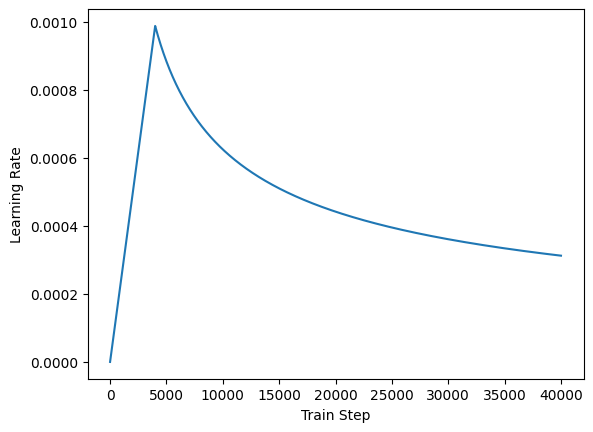

In [335]:
import matplotlib.pyplot as plt

plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

#### Thiết lập loss and metrics 

In [339]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [340]:
loss_object

In [341]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


In [342]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

#### Transformer

In [343]:
transformer = Transformer(
    num_layers, 
    d_model, 
    num_heads, 
    dff,
    encoder_vocab_size, 
    decoder_vocab_size, 
    pe_input=encoder_vocab_size, 
    pe_target=decoder_vocab_size,
)


#### Masks

In [347]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

#### Checkpoints

In [349]:
# checkpoint_path = "/kaggle/input/model-test/checkpoints"

# ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=2)

# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print ('Latest checkpoint restored!!')

In [350]:
load_checkpoint_path = "/kaggle/input/model-test/kaggle/working/new_checkpoints"
load_ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

load_ckpt_manager = tf.train.CheckpointManager(load_ckpt, load_checkpoint_path, max_to_keep=1)

if load_ckpt_manager.latest_checkpoint:
    load_ckpt.restore(load_ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored from:', load_ckpt_manager.latest_checkpoint)

save_checkpoint_path = "/kaggle/working/new_checkpoints"
save_ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
save_ckpt_manager = tf.train.CheckpointManager(save_ckpt, save_checkpoint_path, max_to_keep=1)


Latest checkpoint restored from: /kaggle/input/model-test/kaggle/working/new_checkpoints/ckpt-12


#### Training steps

In [351]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)

@tf.function
def test_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    predictions, _ = transformer(
        inp, tar_inp, 
        False, 
        enc_padding_mask, 
        combined_mask, 
        dec_padding_mask
    )
    loss = loss_function(tar_real, predictions)
    test_loss(loss)

In [92]:
# (129152, 14400)
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()

    # Training loop
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 1009 == 0:
            print('Epoch {} Batch {} Train Loss {:.4f}'.format(epoch + 1, batch, train_loss.result()))

    print('Epoch {} Train Loss {:.4f}'.format(epoch + 1, train_loss.result()))
    if (epoch + 1) % 2 == 0:
        ckpt_save_path = save_ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch + 1, ckpt_save_path))

    # Test loop
    test_loss.reset_states()
    for (batch, (inp, tar)) in enumerate(test_dataset):
        test_step(inp, tar)

        if batch % 112 == 0:
            print('Epoch {} Batch {} Test Loss {:.4f}'.format(epoch + 1, batch, test_loss.result()))

    print('Epoch {} Test Loss {:.4f}'.format(epoch + 1, test_loss.result()))
    
    print('Time taken for epoch {}: {} secs\n'.format(epoch + 1, time.time() - start))


Epoch 1 Batch 0 Train Loss 7.5934
Epoch 1 Batch 1009 Train Loss 6.3560
Epoch 1 Train Loss 5.8238
Epoch 1 Batch 0 Test Loss 5.0568
Epoch 1 Batch 112 Test Loss 4.9915
Epoch 1 Batch 224 Test Loss 4.9903
Epoch 1 Test Loss 4.9903
Time taken for epoch 1: 1327.4644522666931 secs

Epoch 2 Batch 0 Train Loss 6.1705
Epoch 2 Batch 1009 Train Loss 4.8581
Epoch 2 Train Loss 4.7315
Saving checkpoint for epoch 2 at /kaggle/working/new_checkpoints/ckpt-1
Epoch 2 Batch 0 Test Loss 4.3821
Epoch 2 Batch 112 Test Loss 4.4789
Epoch 2 Batch 224 Test Loss 4.4710
Epoch 2 Test Loss 4.4710
Time taken for epoch 2: 1320.8234004974365 secs

Epoch 3 Batch 0 Train Loss 5.6713
Epoch 3 Batch 1009 Train Loss 4.4321
Epoch 3 Train Loss 4.3493
Epoch 3 Batch 0 Test Loss 3.9988
Epoch 3 Batch 112 Test Loss 4.2110
Epoch 3 Batch 224 Test Loss 4.2189
Epoch 3 Test Loss 4.2189
Time taken for epoch 3: 1317.8638324737549 secs

Epoch 4 Batch 0 Train Loss 5.2619
Epoch 4 Batch 1009 Train Loss 4.1245
Epoch 4 Train Loss 4.0884
Saving ch

In [358]:
total_batches = len(dataset)
total_train_batches = len(train_dataset)

for epoch in range(5):
    start = time.time()

    train_loss.reset_states()
    test_loss.reset_states()

    combined_bar = tqdm(enumerate(dataset), total=total_batches, desc=f'Epoch {epoch + 1} / {EPOCHS}')
    for batch, (inp, tar) in combined_bar:
        if batch < total_train_batches:
            # Training step
            train_step(inp, tar)
            combined_bar.set_postfix({'Train Loss': train_loss.result().numpy()}, refresh=True)
        else:
            # Test step
            test_step(inp, tar)
            combined_bar.set_postfix({'Train Loss': train_loss.result().numpy(), 'Test Loss': test_loss.result().numpy()}, refresh=True)

            
    print('Time taken for epoch {}: {} secs\n'.format(epoch + 1, time.time() - start))
    # Save checkpoint after each training epoch
    if (epoch + 1) % 1 == 0:
        ckpt_save_path = save_ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch + 1, ckpt_save_path))



Epoch 1 / 20: 100%|██████████| 2243/2243 [22:14<00:00,  1.68it/s, Train Loss=2.95, Test Loss=4.08]


Time taken for epoch 1: 1334.703792333603 secs

Saving checkpoint for epoch 1 at /kaggle/working/new_checkpoints/ckpt-1


Epoch 2 / 20: 100%|██████████| 2243/2243 [22:12<00:00,  1.68it/s, Train Loss=2.94, Test Loss=4.08]


Time taken for epoch 2: 1332.991801738739 secs

Saving checkpoint for epoch 2 at /kaggle/working/new_checkpoints/ckpt-2


Epoch 3 / 20: 100%|██████████| 2243/2243 [22:12<00:00,  1.68it/s, Train Loss=2.93, Test Loss=4.06]


Time taken for epoch 3: 1332.852679491043 secs

Saving checkpoint for epoch 3 at /kaggle/working/new_checkpoints/ckpt-3


Epoch 4 / 20: 100%|██████████| 2243/2243 [22:13<00:00,  1.68it/s, Train Loss=2.92, Test Loss=4.05]


Time taken for epoch 4: 1333.3386421203613 secs

Saving checkpoint for epoch 4 at /kaggle/working/new_checkpoints/ckpt-4


Epoch 5 / 20: 100%|██████████| 2243/2243 [22:13<00:00,  1.68it/s, Train Loss=2.91, Test Loss=4.03]


Time taken for epoch 5: 1333.7196848392487 secs

Saving checkpoint for epoch 5 at /kaggle/working/new_checkpoints/ckpt-5


### Inference

#### Dự đoán từng từ một tại decoder và thêm nó vào đầu ra; sau đó lấy chuỗi hoàn chỉnh làm đầu vào cho decoder và lặp lại cho đến khi từ khóa maxlen hoặc [end] xuất hiện

In [359]:
def evaluate(input_document, model):
    input_document = document_tokenizer.texts_to_sequences([input_document])
    input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_document[0], 0)

    decoder_input = [summary_tokenizer.word_index["[start]"]]
    output = tf.expand_dims(decoder_input, 0)
    for i in range(decoder_maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = model(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == summary_tokenizer.word_index["[end]"]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights


In [360]:
def summarize(input_document, model):
    summarized = evaluate(input_document=input_document, model=model)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  # not printing <go> token
    return summary_tokenizer.sequences_to_texts(summarized)[0].replace('_', ' ')  # since there is just one translated document

In [364]:
idx = 100
print(f'text: {document[idx]} \n')
print(f'summary original: {summary[idx]} \n')
print(f'summary model: {summarize(document[idx], transformer)}')

text: Vai_Bắc_Đẩu với thời_lượng xuất_hiện từ đầu tới cuối chương_trình , phải tương_tác liên_tục cùng các bạn diễn , số_lượng lời thoại nhiều bậc nhất dàn diễn_viên , sẽ là vai nặng_ký với bất_kỳ diễn_viên nào . Sẽ rất khó để tìm được diễn_viên có_thể thay_thế những dấu_ấn mà NSND Công_Lý đã để lại cho Bắc_Đẩu . Bắc_Đẩu qua sự thể_hiện của Công_Lý vừa đanh_đá , chua_ngoa vừa tưng_tửng , vừa nữ_tính vừa nam_tính đến thô_kệch , vừa sắc_sảo vừa hài_hước . Với điều_kiện sức_khoẻ hiện_tại , khi NSND Công_Lý không_thể tiếp_tục đảm_đương vai Bắc_Đẩu , kịch_bản Táo_Quân sẽ cần đến những tình_tiết chuyển_giao , cần đến màu_sắc mới cho Bắc_Đẩu mới . Với gần 20 năm lên sóng , “ Cô Đẩu ” Công_Lý đã là một cá_tính riêng_biệt không_thể trộn lẫn của dàn Táo_Quân . Vắng_Bắc_Đẩu_Công Lý , trên các diễn_đàn mạng xã_hội , khán_giả nhắc nhớ kỹ_thuật diễn , nhả thoại đặc_biệt của NSND Công_Lý , và nhắc đến hàng_loạt những câu thoại đã được NSND Công_Lý thể_hiện với sự tưng_tửng , chanh_chua . Trong đó , n

#### nén checkpoint

In [365]:
!zip -r checkpoints_v4.zip /kaggle/working/new_checkpoints

  adding: kaggle/working/new_checkpoints/ (stored 0%)
  adding: kaggle/working/new_checkpoints/ckpt-5.data-00000-of-00001 (deflated 20%)
  adding: kaggle/working/new_checkpoints/ckpt-5.index (deflated 80%)
  adding: kaggle/working/new_checkpoints/checkpoint (deflated 39%)


#### load một tập dữ liệu để đánh giá độ chính xác

In [379]:
eval_data = pd.read_csv('/kaggle/input/dataset2/Dataset_articles_NoID-7.csv')
eval_data.drop(['URL', 'Title', 'Date', 'Author(s)', 'Category', 'Tags'], axis=1, inplace=True)
eval_data.dropna(inplace=True)
eval_data.drop_duplicates(inplace=True)

In [380]:
eval_data

,Summary,Contents
0,"Với kết quả hòa 0-0 U23 Syria, thầy trò HLV Pa...","Hết giờ, U23 Việt Nam hòa 0-0 và giành tấm vé ..."
1,"Sau vòng 1 thi đấu nhàn nhã, Nadal đã phải mất...",Với lối đánh tấn công dồn dập ngay từ đầu trận...
2,"Sau 2 trận đấu trước Hàn Quốc, Australia tại V...","Trong trận đấu ra quân gặp U23 Hàn Quốc, từ tì..."
4,U23 Việt Nam sẽ đối đầu với U23 Syria trong tr...,Từ khoá “Syria” khiến nhiều khán giả nhớ đến h...
5,Từ lúc vượt qua vòng loại cho đến khi đã trải ...,"Sau vòng loại, với tư cách là đội có thành tíc..."
...,...,...
13303,"Sáng nay (7.10) tại tỉnh Quảng Trị, đồng chí N...",Đoàn cứu trợ đã trực tiếp về huyện Vĩnh Linh v...
13304,"Sáng nay (7.10), tại Nghệ An, Quỹ Tấm lòng vàn...",Đồng chí Phạm Anh Tuấn cũng cho biết: Chiều qu...
13306,Đại diện Quỹ Tấm lòng Lao Động và LĐLĐ Phú Yên...,Số tiền trên được trích từ nguồn Quỹ Tấm lòng ...
13307,"Tính đến chiều 5.10, Quỹ Tấm lòng vàng (TLV) L...","Theo đó, Quỹ TLV Lao Động quyết định hỗ trợ 6..."


In [5]:
eval_data = eval_data[eval_data['Contents'].swifter.apply(lambda x: 50 < len(x.split()))]
eval_data = eval_data[eval_data['Summary'].swifter.apply(lambda x: 5 < len(x.split()))]
eval_data['Contents'] = eval_data['Contents'].swifter.apply(process_text)
eval_data['Summary'] = eval_data['Summary'].swifter.apply(process_text)

In [384]:
eval_data

,Summary,Contents
0,"Với kếtquả hoà 0-0 U23 Syria , thầytrò HLV Par...","Hết giờ , U23 Việt_Nam hoà 0-0 và giành tấm vé..."
1,"Sau vòng 1 thiđấu nhànnhã , Nadal đã phải mất ...",Với lối đánh tấn_công dồn_dập ngay từ đầu trận...
2,"Sau 2 trận đấu trước HànQuốc , Australia tại V...","Trong trận đấu ra_quân gặp U23 Hàn_Quốc , từ t..."
4,U23 ViệtNam sẽ đốiđầu với U23 Syria trong trận...,Từ_khoá Syria khiến nhiều khán_giả nhớ đến hìn...
5,Từ lúc vượt qua vòngloại cho đến khi đã trải q...,"Sau vòng_loại , với tư_cách là đội có thành_tí..."
...,...,...
13303,"Sáng nay ( 7.10 ) tại tỉnh QuảngTrị , đồngchí ...",Đoàn cứu_trợ đã trực_tiếp về huyện Vĩnh_Linh v...
13304,"Sáng nay ( 7.10 ) , tại NghệAn , QuỹTấm lòng v...",Đồng_chí Phạm_Anh_Tuấn cũng cho biết Chiều_qua...
13306,Đạidiện_QuỹTấm lòng LaoĐộng và LĐLĐ PhúYên vừa...,Số tiền trên được trích từ nguồn Quỹ_Tấm lòng ...
13307,"Tính đến chiều 5.10 , QuỹTấm lòng vàng ( TLV )...","Theo đó , Quỹ_TLV_Lao_Động quyết_định hỗ_trợ 6..."


In [396]:
def evaluate_rouge(datas, model):
    rouge_metric = load_metric('rouge')
    texts = datas['Contents']
    summaries = datas['Summary']
    references = []
    predictions = []
    for i in range(len(texts)):
        text = texts.iloc[i]
        actual = summaries.iloc[i]
        output = summarize(text, model)
        references.append(actual)
        predictions.append(output)
        print('.', end='', flush=True)
    rouge_metric.add_batch(predictions=predictions, references=references)
    rouge_scores = rouge_metric.compute()
    print(rouge_scores)
    return rouge_scores

In [6]:
evaluate_rouge(datas=eval_data.iloc[:1000], model=transformer)